In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## 1. Data



In [44]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [45]:
n_samples, n_features = X_train.shape
print('Les données d\'entraînement contiennent : {} échantillons de dimension {}'.format(n_samples, n_features))
print('Les données de test contiennent : {} échantillons de dimension {}'.format(X_test.shape[0], X_test.shape[1]))

Les données d'entraînement contiennent : 1494 échantillons de dimension 35
Les données de test contiennent : 654 échantillons de dimension 35


### Description des données

In [46]:
with pd.option_context('display.max_columns', None):
    display(X_train.head())

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [47]:
y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


Les données d'entrée possèdent 35 colonnes :

- ID : Identifiant d'indexe unique, associé à un jour (DAY_ID) et un pays (COUNTRY),
- DAY_ID : Identifiant du jour - les dates ont été annonymisées en préservant la structure des données,
- COUNTRY : Identifiant du pays - DE = Allemagne, FR = France, 

et composées ensuite de variations journalières du prix de matières premières,

- GAS_RET : Gaz en Europe,
- COAL_RET : Charbon en Europe,
- CARBON_RET : Futures sur les emissions carbone, 

de mesures météorologiques (journalières, dans le pays x),

- x_TEMP : Temperature,
- x_RAIN : Pluie,
- x_WIND : Vent,

de mesures de productions d'energie (journalière, dans le pays x),

- x_GAS : Gaz naturel,
- x_COAL : Charbon,
- x_HYDRO : Hydrolique,
- x_NUCLEAR : Nucléaire,
- x_SOLAR : Photovoltaïque,
- x_WINDPOW : Eolienne,
- x_LIGNITE : Lignite,

et de mesures d'utilisation électrique (journalières, dans le pays x),

- x_CONSUMPTON : Electricité totale consommée,
- x_RESIDUAL_LOAD : Electricité consommée après utilisation des énergies renouvelables,
- x_NET_IMPORT: Electricité importée depuis l'Europe,
- x_NET_EXPORT: Electricité exportée vers l'Europe,
- DE_FR_EXCHANGE: Electricité échangée entre Allemagne et France,
- FR_DE_EXCHANGE: Electricité échangée entre France et Allemagne.



#### Commentaires:
- Dans le benchmarck FR et DE sont traités de la même facon. Vaut-il mieux les traiter séparamment.
- Si nous construisons deux modèles distincts, alors le dataset perdra considérablement en terme de qualité. En effet nous diviserons presque par deux le nombre d'observations pour chaque modèle
- Il faudrait donc améliorer le jeu de données pour pouvoir construire un unique modèle de prédiction qualitatif.

In [48]:
X_train["DAY_ID"].value_counts().head(1000)


DAY_ID
77      2
237     2
231     2
1001    2
1070    2
       ..
0       1
308     1
721     1
969     1
90      1
Name: count, Length: 851, dtype: int64

In [49]:
day_ids = [77, 237, 231, 1001, 1070, 1112, 908, 757, 542, 391]

X_train[X_train["DAY_ID"].isin(day_ids)].sort_values("DAY_ID")


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
492,1278,77,FR,0.204839,-0.556874,-0.868887,0.868887,-0.923998,0.858085,0.923998,...,-0.606544,-1.316356,-0.173395,-0.419634,-0.195610,-1.597233,-0.701258,-1.394954,-0.403791,-0.316186
852,62,77,DE,0.204839,-0.556874,-0.868887,0.868887,-0.923998,0.858085,0.923998,...,-0.606544,-1.316356,-0.173395,-0.419634,-0.195610,-1.597233,-0.701258,-1.394954,-0.403791,-0.316186
550,2060,231,FR,-0.511138,-0.802438,0.938683,-0.938683,-0.723702,-2.174215,0.723702,...,-0.779227,-1.516457,-0.478945,0.909630,0.100861,0.171330,0.453644,-0.664758,-0.189012,-0.667172
1212,844,231,DE,-0.511138,-0.802438,0.938683,-0.938683,-0.723702,-2.174215,0.723702,...,-0.779227,-1.516457,-0.478945,0.909630,0.100861,0.171330,0.453644,-0.664758,-0.189012,-0.667172
561,1363,237,FR,0.664205,0.326647,-0.213652,0.213652,-0.027239,-0.462336,0.027239,...,0.349165,0.045906,-0.739773,-0.849181,-0.669926,-0.193674,-0.369820,0.444776,-0.193880,0.318229
567,147,237,DE,0.664205,0.326647,-0.213652,0.213652,-0.027239,-0.462336,0.027239,...,0.349165,0.045906,-0.739773,-0.849181,-0.669926,-0.193674,-0.369820,0.444776,-0.193880,0.318229
560,2050,391,FR,-0.305770,-0.818128,0.397849,-0.397849,-0.299681,-1.494674,0.299681,...,-0.997108,-0.450657,-0.108242,1.390915,1.370472,-0.380167,0.859136,-1.033335,0.604034,-1.409869
1364,834,391,DE,-0.305770,-0.818128,0.397849,-0.397849,-0.299681,-1.494674,0.299681,...,-0.997108,-0.450657,-0.108242,1.390915,1.370472,-0.380167,0.859136,-1.033335,0.604034,-1.409869
559,646,542,DE,1.166555,-0.318736,-0.243236,0.243236,0.976377,0.877926,-0.976377,...,-1.091336,-0.420718,-0.471684,2.543151,3.499060,1.297569,1.306755,-0.371456,2.309202,0.717430
960,1862,542,FR,1.166555,-0.318736,-0.243236,0.243236,0.976377,0.877926,-0.976377,...,-1.091336,-0.420718,-0.471684,2.543151,3.499060,1.297569,1.306755,-0.371456,2.309202,0.717430


In [50]:
y_train.loc[[1278, 62]]

,ID,TARGET
1278,878,-0.444789
62,1560,-0.532471


#### Commentaires 
- On observe que les features de certaines dates sont utilisés deux fois dans le dataset : une fois pour décrire la Variation du prix de l'électricté en France, et l'autre fois pour décrire celle en Allemagne
- On observe aussi que les même feautures  ont des impacts totalement différents sur la variation du prix de l'éléctricité en Allemagne ou en France. Il serait donc judicieux de bien préparer le set de données avant de passer à la modélisation.
- Une solution serait de modifier COUNTRY en une variable binaire prenant des valeurs {0,1}.

Nous allons procéder à pré-traitement du dataset

In [51]:
# concatener x_train et y_train pour avoir toutes les données ensemble
import pandas as pd

X= X_train.merge(
    y_train[["ID", "TARGET"]],
    on="ID",
    how="inner"
)


### Les valeurs manquantes
- Pour les données numériques, nous souhaitons remplacer les données manquantes avec la méthode ffil. Cette méthode nécessite d'uiliser des séries temporelles, il faut donc trier les données par ordre chronologique. POur cela nous allons séparer le dataset en deux : les variations allemandes et françaises, puis au sein de ces deux datasets nous trirons les données dans le l'ordre chronologique, puis nous appliquerons la méthode "ffill".
- De plus pour la colonne "COUNTRY" nous allons la rendre binaire.

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [53]:
with pd.option_context('display.max_columns', None):
    display(X_train.isna().sum())

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64

In [54]:
numeric_features = ['GAS_RET',
                     'COAL_RET', 
                     'CARBON_RET',
                     'DE_TEMP',
                     'DE_RAIN',
                     'DE_WIND',
                     'DE_GAS',
                     'DE_COAL',
                     'DE_HYDRO',
                     'DE_NUCLEAR',
                     'DE_SOLAR',
                     'DE_WINDPOW',
                     'DE_LIGNITE',
                     'DE_CONSUMPTION',
                     'DE_RESIDUAL_LOAD',
                     'DE_NET_IMPORT',
                     'DE_NET_EXPORT',
                     'FR_TEMP',
                     'FR_RAIN',
                     'FR_WIND',
                     'FR_GAS',
                     'FR_COAL',
                     'FR_HYDRO',
                     'FR_NUCLEAR',
                     'FR_SOLAR',
                     'FR_WINDPOW',
                     'FR_CONSUMPTION',
                     'FR_RESIDUAL_LOAD',
                     'FR_NET_IMPORT',
                     'FR_NET_EXPORT',
                     'DE_FR_EXCHANGE',
                     'FR_DE_EXCHANGE']
categorical_features = ['COUNTRY']

In [55]:
X_DE = X_train[X_train['COUNTRY'] == 'DE']
X_FR = X_train[X_train['COUNTRY'] == 'FR']
X_DE_test= X_test[X_test['COUNTRY'] == 'DE']
X_FR_test= X_test[X_test['COUNTRY'] == 'FR']

print(f"Le dataset allemand comporte {len(X_DE)} échantillons.")
print(f"Le dataset français comporte {len(X_FR)} échantillons.")

Le dataset allemand comporte 643 échantillons.
Le dataset français comporte 851 échantillons.


In [56]:
# trier les datasets par ordre chronologique (DAY_ID)
X_DE = X_DE.sort_values("DAY_ID")
X_FR = X_FR.sort_values("DAY_ID")
X_DE_test = X_DE_test.sort_values("DAY_ID")
X_FR_test = X_FR_test.sort_values("DAY_ID")

# POur les features numériques : Appliquer forward fill, et 0 si première valeur
X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)
X_DE_test[numeric_features] = X_DE_test[numeric_features].fillna(method='ffill').fillna(0)
X_FR_test[numeric_features] = X_FR_test[numeric_features].fillna(method='ffill').fillna(0)

X_train = pd.concat([X_DE, X_FR])
X_test= pd.concat([X_DE_test, X_FR_test])


X_train["COUNTRY"] = (X_train["COUNTRY"] == "FR").astype(int) # FR=1, DE=0
X_test["COUNTRY"] = (X_test["COUNTRY"] == "FR").astype(int) # FR=1, DE=0




/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_24759/3925968088.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_DE[numeric_features] = X_DE[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_24759/3925968088.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_FR[numeric_features] = X_FR[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_24759/3925968088.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_DE_test[numeric_features] = X_DE_test[numeric_features].fillna(method='ffill').fillna(0)
/var/folders/nq/qwtx6rd54k7686m_s4y2mxpw0000gn/T/ipykernel_24759/3925968088.py:11: Fut

In [57]:
with pd.option_context('display.max_columns', None):
    display(X_train.head())
    display(X_train.tail())


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
1468,111,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434
680,800,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,-0.383690,-2.002323,-1.579208,1.527633,2.986527,-1.142488,-0.718643,-0.169336,0.275487,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756
991,831,5,0,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,1.811403,1.059828,0.528273,-0.072071,-0.766063,1.275857,-0.398178,-1.875681,-1.866010,2.551925,3.425813,-0.892244,-0.640389,-0.279690,-0.031595,-0.552878,-1.374757,-0.790071,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870
1356,779,7,0,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,0.745182,0.386191,0.727314,0.255380,-0.778036,0.281094,-0.739291,-1.887303,-1.934168,1.654025,2.276123,-0.876909,-0.079343,0.108801,0.142427,-0.806379,-0.531862,-0.663419,0.098940,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642
713,841,8,0,-0.282744,-0.700027,1.309253,-1.309253,0.248085,-2.226840,-0.248085,2.226840,0.955400,0.278566,-0.234473,-0.755877,0.385716,-0.580103,-1.889094,-2.414937,1.267943,2.554835,0.274719,-0.318923,-0.245104,-0.508221,-0.791016,1.522720,-0.307449,1.690497,1.584210,-0.441943,-0.382423,1.557325,0.146634,2.329924


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
479,2039,1208,1,0.046568,-0.709011,0.427976,-0.427976,-0.578391,-1.678101,0.578391,1.678101,1.391369,0.179728,0.069929,-0.758579,1.620765,-0.380974,-1.891245,-1.903612,2.135312,1.061313,-0.572220,-0.468104,0.141485,0.151799,-0.666261,-1.224735,2.661142,0.472212,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742
1451,972,1209,1,1.109804,1.301061,1.565552,-1.565552,-0.578391,-1.678101,0.578391,1.678101,0.271184,0.919401,1.156111,0.167770,-0.922397,0.920620,0.151197,1.036172,-0.298578,0.340548,0.901121,1.033972,1.046201,0.062332,1.038585,0.457145,-0.202629,-0.395438,-0.463636,-0.251075,-0.387127,-0.411589,1.774694,1.038661
1007,1987,1212,1,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,-0.906285,-1.885215,-1.434474,1.859448,1.589641,-0.245558,-0.266687,-0.159332,-0.623925,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792
873,1688,1213,1,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,1.549682,-0.451947,-0.291751,-0.749000,1.933776,0.142984,0.258724,-0.994097,-0.365253,0.531472,2.298943,0.414313,0.849643,0.868310,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,-0.103642,-0.633007,0.214805
1437,1049,1215,1,0.544810,-0.378158,-0.065993,0.065993,0.333142,0.257829,-0.333142,-0.257829,0.233317,-0.014042,0.872465,0.376881,1.911476,0.780039,0.707865,-0.455935,1.641548,0.896832,-0.996035,-0.951987,0.956420,0.733495,-0.223383,-0.646163,0.738201,-0.903380,-0.882630,-0.247278,0.755489,0.758698,0.078518,0.192945


In [58]:
X_train.isna().sum()

ID                  0
DAY_ID              0
COUNTRY             0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64

notes Tania : je pense que le onehot encoder n'est pas necessaire puisque on a juste 2 type de données. aussi il n'ya pas de NA pour la variable country

### Feature ingenering 

In [59]:
X_train['DAY_ID'].describe()

count    1494.000000
mean      591.861446
std       345.065043
min         0.000000
25%       292.250000
50%       591.000000
75%       885.750000
max      1215.000000
Name: DAY_ID, dtype: float64

In [60]:
X_test['DAY_ID'].describe()

count     654.000000
mean      632.744648
std       356.751037
min         4.000000
25%       334.000000
50%       633.500000
75%       952.000000
max      1214.000000
Name: DAY_ID, dtype: float64

Les jours vont de 0 à 1215 on ne peut pas faire grand chose, on ne peut pas creer de variables weekly. Cependant on peut essayer de creer des time block.

In [61]:
X_train["time_block"] = pd.qcut(X_train["DAY_ID"], q=4, labels=False)
X_test["time_block"] = pd.qcut(X_test["DAY_ID"], q=4, labels=False)



#### variations journalières du prix de matières premières

les variations jouranlieres brut des matieres premieres sont tres bruités. Il est recommandé dans les papiers (Weron (2014) – Electricity price forecasting) les regime indicators sur fuel prices. on calcule d'baord une moyenne mobile sur 7 jours puis on calcul puis on separe en 3 quantiles : "low", "medium", "high"

In [62]:
X_DE = X_train[X_train['COUNTRY'] == 0]
X_FR = X_train[X_train['COUNTRY'] == 1]
X_DE_test= X_test[X_test['COUNTRY'] == 0]
X_FR_test= X_test[X_test['COUNTRY'] == 1]

X_DE = X_DE.sort_values("DAY_ID")
X_FR = X_FR.sort_values("DAY_ID")
X_DE_test = X_DE_test.sort_values("DAY_ID")
X_FR_test = X_FR_test.sort_values("DAY_ID")

def rolling_mean_features(df, target_col, window_size=7):
    for col in target_cols:
        df[col + "_MA_7"] = df[col].rolling(window=window_size, min_periods=1).mean()
    return df

target_cols = ['GAS_RET', 'COAL_RET', 'CARBON_RET']
X_DE = rolling_mean_features(X_DE, target_cols)
X_FR = rolling_mean_features(X_FR, target_cols)
X_DE_test = rolling_mean_features(X_DE_test, target_cols)
X_FR_test = rolling_mean_features(X_FR_test, target_cols)   

X_train = pd.concat([X_DE, X_FR])
X_test= pd.concat([X_DE_test, X_FR_test])




In [63]:
display(X_train.head())
display(X_train.tail())

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,time_block,GAS_RET_MA_7,COAL_RET_MA_7,CARBON_RET_MA_7
1468,111,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,0,1.802550,1.140920,0.900434
680,800,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0,1.121336,0.538185,0.433839
991,831,5,0,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,0,0.708232,0.542268,0.549849
1356,779,7,0,0.057599,-0.625625,0.002239,-0.002239,-0.676226,-0.745182,0.676226,...,1.367421,-0.812164,0.954384,-0.379980,0.518459,-0.034642,0,0.436179,0.536315,0.403727
713,841,8,0,-0.282744,-0.700027,1.309253,-1.309253,0.248085,-2.226840,-0.248085,...,1.584210,-0.441943,-0.382423,1.557325,0.146634,2.329924,0,0.660408,0.458379,0.788966


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,time_block,GAS_RET_MA_7,COAL_RET_MA_7,CARBON_RET_MA_7
479,2039,1208,1,0.046568,-0.709011,0.427976,-0.427976,-0.578391,-1.678101,0.578391,...,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742,3,-0.046914,0.469676,-0.092219
1451,972,1209,1,1.109804,1.301061,1.565552,-1.565552,-0.578391,-1.678101,0.578391,...,-0.463636,-0.251075,-0.387127,-0.411589,1.774694,1.038661,3,-0.118148,0.773734,-0.022019
1007,1987,1212,1,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,...,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,3,-0.167486,0.631489,-0.017537
873,1688,1213,1,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,...,1.123953,-0.707839,-0.308232,-0.103642,-0.633007,0.214805,3,-0.208687,0.504285,-0.059291
1437,1049,1215,1,0.544810,-0.378158,-0.065993,0.065993,0.333142,0.257829,-0.333142,...,-0.882630,-0.247278,0.755489,0.758698,0.078518,0.192945,3,0.099937,0.596258,0.196266


on separe les regime indicators apres avoir fait le split test/val pour ne pas avoir de fuite

#### mesure de production

les interaction meteo x production sont tres influents sur le prix de l'electrcité. Un jour très venteux avec beaucoup d’éolien=prix plus bas. un jour venteux mais peu d’éolien = effet faible (Ziel & Weron (2018), Gianfreda et al. (2016))

In [64]:
# interactions vent × éolien
X_train["DE_WIND_WINDPOW"] = X_train["DE_WIND"] * X_train["DE_WINDPOW"]
X_train["FR_WIND_WINDPOW"] = X_train["FR_WIND"] * X_train["FR_WINDPOW"]

# température × residual load
X_train["DE_TEMP_RESLOAD"] = X_train["DE_TEMP"] * X_train["DE_RESIDUAL_LOAD"]

X_train["FR_TEMP_RESLOAD"] = X_train["FR_TEMP"] * X_train["FR_RESIDUAL_LOAD"]

# pluie × hydro
X_train["DE_RAIN_HYDRO"] = X_train["DE_RAIN"] * X_train["DE_HYDRO"]

X_train["FR_RAIN_HYDRO"] = X_train["FR_RAIN"] * X_train["FR_HYDRO"]


X_test["DE_WIND_WINDPOW"] = X_test["DE_WIND"] * X_test["DE_WINDPOW"]
X_test["FR_WIND_WINDPOW"] = X_test["FR_WIND"] * X_test["FR_WINDPOW"]
X_test["DE_TEMP_RESLOAD"] = X_test["DE_TEMP"] * X_test["DE_RESIDUAL_LOAD"]
X_test["FR_TEMP_RESLOAD"] = X_test["FR_TEMP"] * X_test["FR_RESIDUAL_LOAD"]
X_test["DE_RAIN_HYDRO"] = X_test["DE_RAIN"] * X_test["DE_HYDRO"]
X_test["FR_RAIN_HYDRO"] = X_test["FR_RAIN"] * X_test["FR_HYDRO"]


consommation

De meme l'interraction entre les exportations/importations et le residual load est important d'apres la litterature. Plus le residual load est élevé, plus le système est sous tension. residual load elevé + import net elevé ca veut dire que le pays n'arrive pas a produire suffisament = prix qui explose 

In [65]:
X_train["LOAD_IMPORT_FR"]=X_train["FR_RESIDUAL_LOAD"] * X_train['FR_NET_IMPORT']
X_train["LOAD_IMPORT_DE"]=X_train["DE_RESIDUAL_LOAD"] * X_train['DE_NET_IMPORT']
X_test["LOAD_IMPORT_FR"]=X_test["FR_RESIDUAL_LOAD"] * X_test['FR_NET_IMPORT']
X_test["LOAD_IMPORT_DE"]=X_test["DE_RESIDUAL_LOAD"] * X_test['DE_NET_IMPORT']


Energies renouvelables et non renouvlables disponibles

In [66]:

X_train['DE_NON_RENEWABLE'] = X_train['DE_GAS'] + X_train['DE_COAL'] + X_train['DE_LIGNITE'] + X_train['DE_NUCLEAR']
X_train['DE_RENEWABLE'] = X_train['DE_HYDRO'] + X_train['DE_SOLAR'] + X_train['DE_WINDPOW']
X_train['DE_EXCESS_ENERGY'] = X_train['DE_NON_RENEWABLE'] + X_train['DE_RENEWABLE'] - X_train['DE_CONSUMPTION']
X_train['FR_NON_RENEWABLE'] = X_train['FR_GAS'] + X_train['FR_COAL'] + X_train['FR_NUCLEAR']
X_train['FR_RENEWABLE'] = X_train['FR_HYDRO'] + X_train['FR_SOLAR'] + X_train['FR_WINDPOW']
X_train['FR_EXCESS_ENERGY'] = X_train['FR_NON_RENEWABLE'] + X_train['FR_RENEWABLE'] - X_train['FR_CONSUMPTION']

X_test['DE_NON_RENEWABLE'] = X_test['DE_GAS'] + X_test['DE_COAL'] + X_test['DE_LIGNITE'] + X_test['DE_NUCLEAR']
X_test['DE_RENEWABLE'] = X_test['DE_HYDRO'] + X_test['DE_SOLAR'] + X_test['DE_WINDPOW']
X_test['DE_EXCESS_ENERGY'] = X_test['DE_NON_RENEWABLE'] + X_test['DE_RENEWABLE'] - X_test['DE_CONSUMPTION'] 
X_test['FR_NON_RENEWABLE'] = X_test['FR_GAS'] + X_test['FR_COAL'] + X_test['FR_NUCLEAR']
X_test['FR_RENEWABLE'] = X_test['FR_HYDRO'] + X_test['FR_SOLAR'] + X_test['FR_WINDPOW']
X_test['FR_EXCESS_ENERGY'] = X_test['FR_NON_RENEWABLE'] + X_test['FR_RENEWABLE'] - X_test['FR_CONSUMPTION'] 

In [67]:
X_train["DE_NET_NET_IMPORT"] = X_train["DE_NET_IMPORT"] - X_train["DE_NET_EXPORT"]
X_train["FR_NET_NET_IMPORT"] = X_train["FR_NET_IMPORT"] - X_train["FR_NET_EXPORT"]
X_test["DE_NET_NET_IMPORT"] = X_test["DE_NET_IMPORT"] - X_test["DE_NET_EXPORT"]
X_test["FR_NET_NET_IMPORT"] = X_test["FR_NET_IMPORT"] - X_test["FR_NET_EXPORT"]

### Valeurs extrêmes

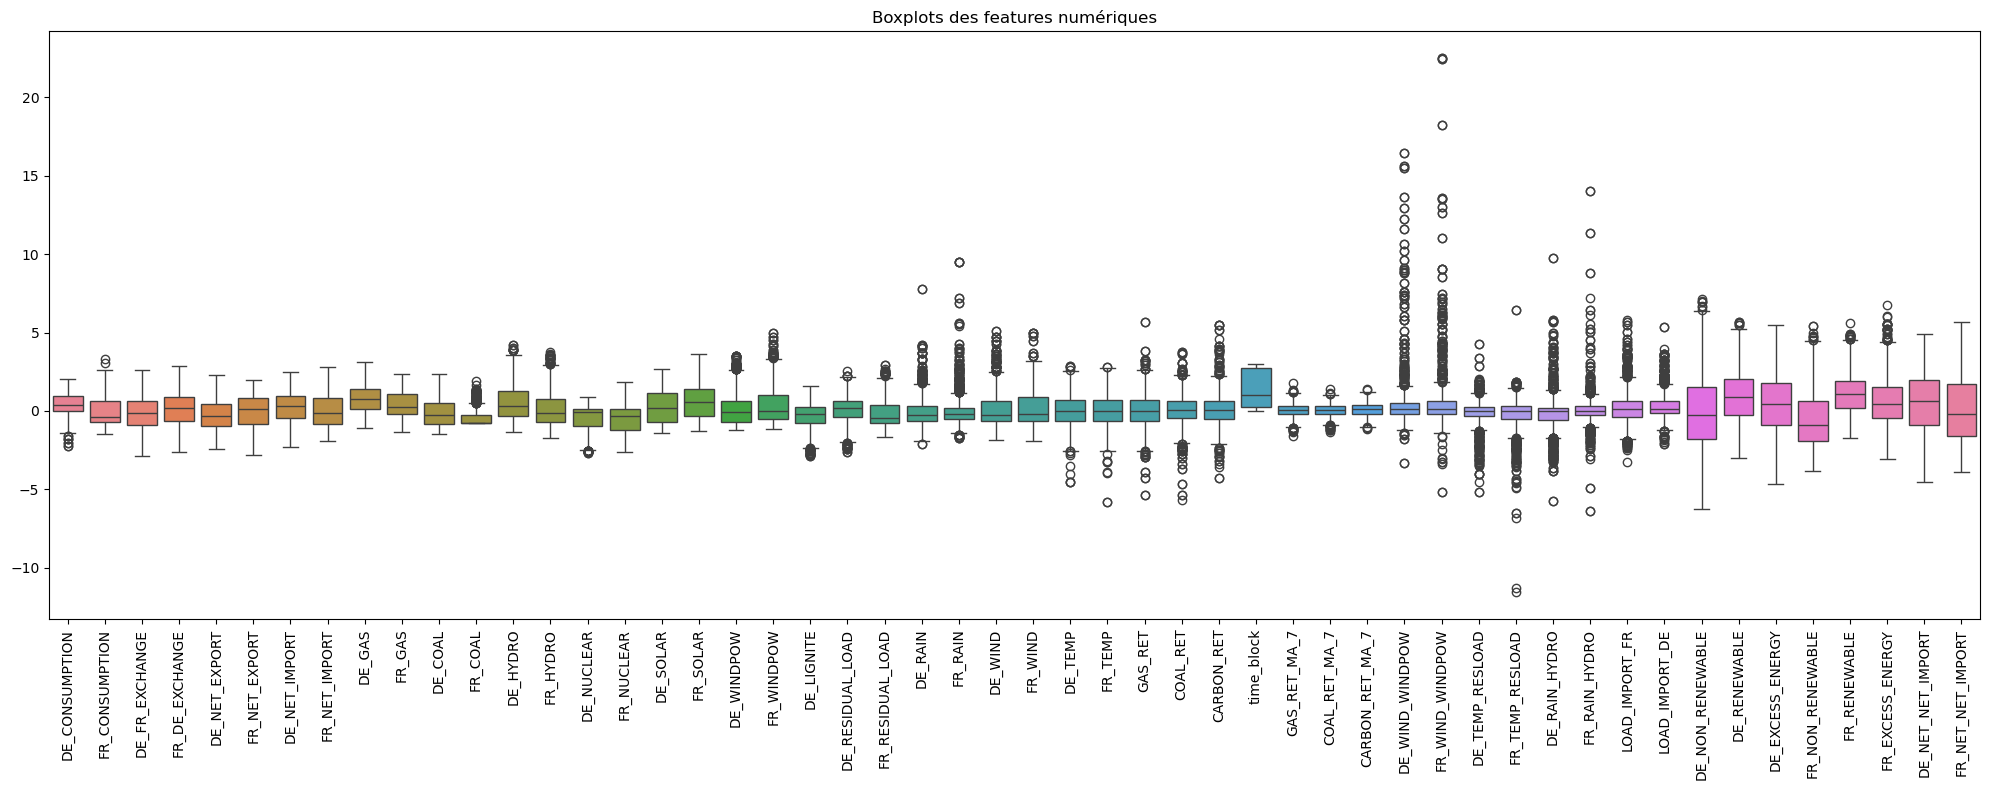

In [68]:
# Boxplot de toutes les features numériques sur un seul graphique
numeric_cols = X_train.drop(columns=categorical_features + ['ID', 'DAY_ID','TARGET'], errors='ignore')

plt.figure(figsize=(20, 8))
sns.boxplot(data=numeric_cols)
plt.xticks(rotation=90)
plt.title('Boxplots des features numériques')
plt.tight_layout()
plt.show()


#### Commentaires:
- Bien que plusieurs variables présentent des valeurs extrêmes, on ne les supprime pas. En effet, ces valeurs correspondent à des événements économiques et météorologiques réels (pics de prix de l’énergie, stress du réseau, conditions météorologiques exceptionnelles) et font partie intégrante du phénomène étudié. Les méthodes de détection d’outliers basées sur des hypothèses de normalité (telles que le Z-score) n’ont donc pas été retenues, afin d’éviter un biais d’échantillonnage et une perte d’information économiquement pertinente 

(cf papier Day-Ahead electricity price forecasting)

La seule exception ce serait les données meteorologiques. On verifie donc qu'il n'existe pas de valeurs impossibles

In [69]:
X_train[["FR_RAIN", "DE_RAIN", "FR_WIND",  "FR_TEMP", "DE_TEMP"]].describe()



,FR_RAIN,DE_RAIN,FR_WIND,FR_TEMP,DE_TEMP
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,0.026846,-0.028403,0.142760,0.017948,0.015869
std,1.090592,0.994910,1.071838,1.009907,0.966265
min,-1.726420,-2.128531,-1.895319,-5.787097,-4.549638
25%,-0.510767,-0.639094,-0.667096,-0.654284,-0.617694
50%,-0.230571,-0.278658,-0.224290,-0.012600,-0.019590
75%,0.156873,0.335708,0.889572,0.702167,0.664786
max,9.473201,7.756118,4.965028,2.817239,2.858758


les valeurs sont normales, il y'a pas de valeur extremes. on ne fait rien.

### Séparation du Dataset en deux jeux : Entraînement et Validation

On sépare notre jeux de données, tout en respectant la chronologie au sein des données allemandes et françaises. L'idée est de prédire le futur. On choisit un séparation 80% / 20%.

In [70]:

split_ratio = 0.8

X_tr_list, X_val_list = [], []
y_tr_list, y_val_list = [], []


#pour chaque pays 
for country_val in X_train["COUNTRY"].unique():
    X_c = X_train[X_train["COUNTRY"] == country_val].copy()
    #on recupere y correspondant (extraire la colonne TARGET pour avoir une Series)
    y_c = y_train.loc[X_c.index, "TARGET"].copy()

    # on s'assure d'un ordre temporel
    X_c = X_c.sort_values("DAY_ID")
    y_c = y_c.loc[X_c.index]

    # on split 
    days = np.sort(X_c["DAY_ID"].unique())
    cutoff_idx = int(len(days) * split_ratio)
    cutoff_day = days[cutoff_idx]

    train_mask = X_c["DAY_ID"] < cutoff_day
    val_mask   = X_c["DAY_ID"] >= cutoff_day

    X_tr_list.append(X_c.loc[train_mask])
    X_val_list.append(X_c.loc[val_mask])
    y_tr_list.append(y_c.loc[train_mask])
    y_val_list.append(y_c.loc[val_mask])

# on concatene les pays
X_tr = pd.concat(X_tr_list).sort_index()
X_val = pd.concat(X_val_list).sort_index()
y_tr = pd.concat(y_tr_list).sort_index()
y_val = pd.concat(y_val_list).sort_index()


In [71]:

#TARGET ne doit pas être dans X
assert "TARGET" not in X_tr.columns
assert "TARGET" not in X_val.columns

# Check dimensions cohérentes
assert len(X_tr) == len(y_tr)
assert len(X_val) == len(y_val)

# Check : les deux pays sont présents dans train et val
print("Train COUNTRY counts:\n", X_tr["COUNTRY"].value_counts())
print("Val   COUNTRY counts:\n", X_val["COUNTRY"].value_counts())

Train COUNTRY counts:
 COUNTRY
1    680
0    514
Name: count, dtype: int64
Val   COUNTRY counts:
 COUNTRY
1    171
0    129
Name: count, dtype: int64


on drop les id

In [72]:
X_tr = X_tr.drop(columns=["ID"], errors="ignore")
X_val = X_val.drop(columns=["ID"], errors="ignore")


### Feature enginnering (bis)

#### variations journalières du prix de matières premières

In [73]:
ma_cols = [
    "GAS_RET_MA_7",
    "COAL_RET_MA_7",
    "CARBON_RET_MA_7",
]

# Calcul des seuils de quantiles sur le jeu d'entraînement
regime_thresholds = {}
for col in ma_cols:
    q_low, q_high = X_tr[col].quantile([1/3, 2/3]).values
    regime_thresholds[col] = (q_low, q_high)

# Fonction pour ajouter les features de régime 3
def add_3regime_features(df: pd.DataFrame, thresholds: dict, suffix="_REG3") -> pd.DataFrame:
    df = df.copy()
    for col, (q_low, q_high) in thresholds.items():
        # returns 0 (low), 1 (mid), 2 (high)
        df[col + suffix] = pd.cut(
            df[col],
            bins=[-np.inf, q_low, q_high, np.inf],
            labels=[0, 1, 2],
            include_lowest=True
        ).astype(int)
    return df

# Ajouter les features de régime 3 aux jeux de données
X_tr  = add_3regime_features(X_tr,  regime_thresholds)
X_val = add_3regime_features(X_val, regime_thresholds)
X_test = add_3regime_features(X_test, regime_thresholds)

### La multicolinéarité

In [74]:
import seaborn as sns

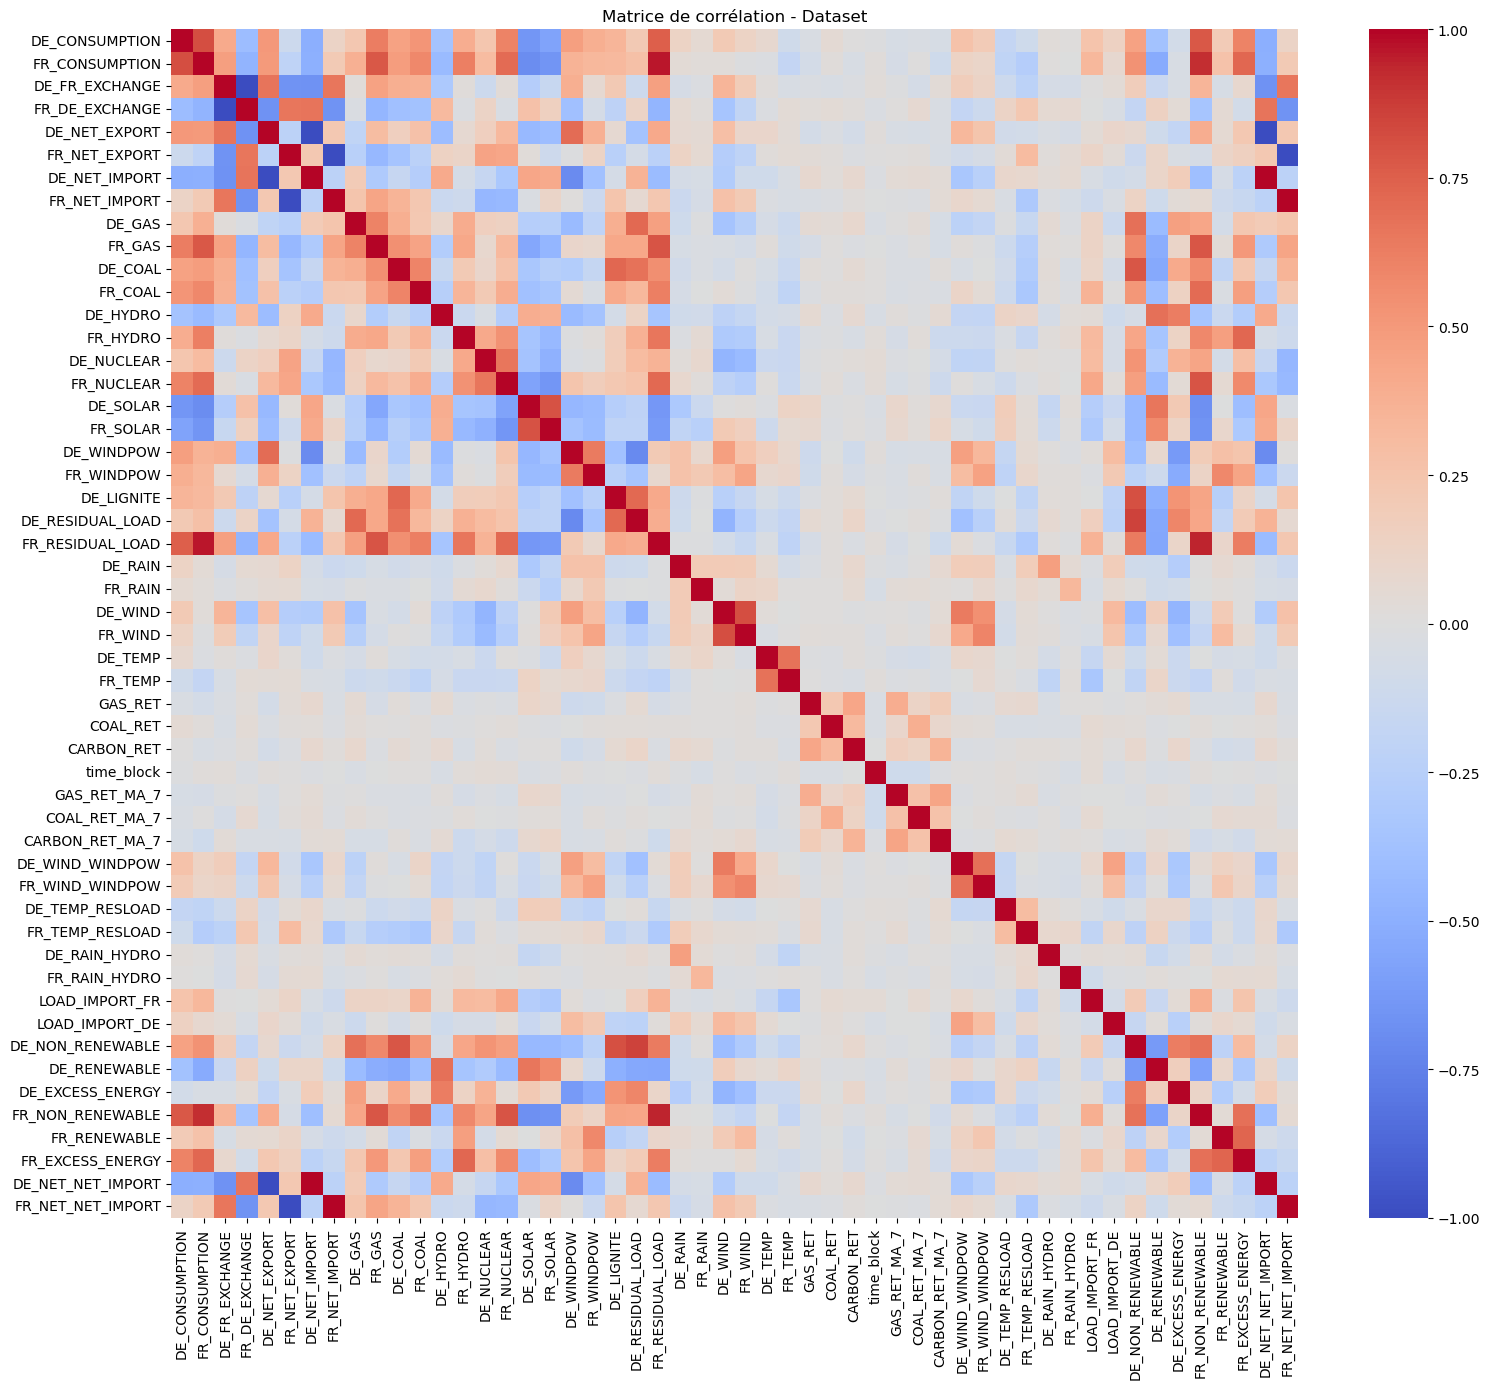

In [75]:
plt.figure(figsize=(16, 14))
numeric_cols = X_train.drop(columns=categorical_features + ['ID', 'DAY_ID', 'COUNTRY_DE', 'COUNTRY_FR'], errors='ignore')
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", annot=False, fmt='.2f', cbar=True)
plt.title('Matrice de corrélation - Dataset')
plt.tight_layout()
plt.show()

In [76]:
# Trouver les colonnes à supprimer pour éviter la multicolinéarité
corr_matrix = numeric_cols.corr()
cols = corr_matrix.columns
cols_corr = []

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.80:
            cols_corr.append((cols[i], cols[j]))

# Supprimer les doublons dans la liste
cols_corr = list(set(cols_corr))

print(f"Les features fortement corrélés sont (corrélation > 0.80):" )
print(cols_corr)

Les features fortement corrélés sont (corrélation > 0.80):
[('DE_NET_EXPORT', 'DE_NET_IMPORT'), ('FR_CONSUMPTION', 'FR_NON_RENEWABLE'), ('DE_NET_EXPORT', 'DE_NET_NET_IMPORT'), ('DE_RESIDUAL_LOAD', 'DE_NON_RENEWABLE'), ('DE_NET_IMPORT', 'DE_NET_NET_IMPORT'), ('FR_NET_EXPORT', 'FR_NET_NET_IMPORT'), ('FR_NET_EXPORT', 'FR_NET_IMPORT'), ('DE_SOLAR', 'FR_SOLAR'), ('FR_CONSUMPTION', 'FR_RESIDUAL_LOAD'), ('FR_NET_IMPORT', 'FR_NET_NET_IMPORT'), ('DE_LIGNITE', 'DE_NON_RENEWABLE'), ('DE_FR_EXCHANGE', 'FR_DE_EXCHANGE'), ('DE_WIND', 'FR_WIND'), ('FR_RESIDUAL_LOAD', 'FR_NON_RENEWABLE'), ('DE_CONSUMPTION', 'FR_CONSUMPTION')]


#### Commentaires : 
- certains feautures sont extrêment corrélés, nous allons donc en supprimer de notre dataset pour éviter la multicolinéarité: "FR_RESIDUAL_LOAD", "DE_SOLAR", "DE_CONSUMPTION", "DE_WIND", "DE_NET_EXPORT", "DE_FR_EXCHANGE", "FR_NET_EXPORT".
-   nous décidons de supprimer les données méthéorologiques allamandes et non françaises, puisque la majorité de nos target values concerent les variations de prix française, nous pensons donc que les données météorologiques françaises seront donc plus significatives en moyennes.
- Concernant les exportations et les importations, il s'agit du calcul net importation - exportation reporté sur les deux variables. Nous supprimons les exportations, ainsi lorsque la variable importation est positive : on importe, lorsque elle est negative on exporte.
- On garde le residual load, d'apres l'etat de l'art assez important 

In [77]:
cols_to_remove = ["FR_NET_EXPORT",
                "DE_NET_EXPORT",
                "FR_NET_IMPORT",
                "DE_NET_IMPORT",
                "DE_LIGNITE",
                "DE_FR_EXCHANGE",
                "DE_WIND",
                "DE_CONSUMPTION",
                "FR_CONSUMPTION",
                "DE_SOLAR"
                ]
X_tr = X_tr.drop(cols_to_remove, axis=1)
X_val = X_val.drop(cols_to_remove, axis=1)
X_test = X_test.drop(cols_to_remove, axis=1)

### Normalisation des données

Etant donné que on a plusieurs valeurs extremes il est necessaire de standariser les données. On fit le scaler sur X_tr uniquement, puis on l'applique de manière équivalente à X_tr et X_val.

In [78]:
from sklearn.preprocessing import StandardScaler

no_scale = ["COUNTRY"]
numeric_cols = [c for c in X_tr.columns if c not in no_scale]
# on fit le scaler sur train
scaler = StandardScaler()
scaler.fit(X_tr[numeric_cols])
# on transforme train et val
X_tr[numeric_cols] = scaler.transform(X_tr[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
# ne pas oublier de scaler aussi le test plus tard
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])



In [79]:
print(y_tr.head())
print(X_tr.head())

0    0.028313
1   -0.112516
2   -0.180840
3   -0.260356
4   -0.071733
Name: TARGET, dtype: float64
     DAY_ID  COUNTRY  FR_DE_EXCHANGE    DE_GAS    FR_GAS   DE_COAL   FR_COAL  \
0 -0.976211        1        0.459399 -0.408733 -0.657756  1.053334  1.414280   
1  0.116256        1       -0.145954 -0.722136  0.049221 -0.028883 -0.641311   
2  0.805066        1       -1.226619  1.838508  1.919876  2.041254  2.369322   
3  0.927274        0        0.700793 -0.353948 -0.207086 -1.577245 -0.688004   
4  1.290195        1        0.789250 -0.646957 -0.687655  1.365884  0.311592   

   DE_HYDRO  FR_HYDRO  DE_NUCLEAR  ...  DE_RENEWABLE  DE_EXCESS_ENERGY  \
0  1.491153  0.100460    1.340823  ...      0.484012          2.151122   
1 -0.348845 -0.863965   -1.541330  ...      0.739128         -0.169271   
2 -0.618818  0.643325   -1.557305  ...     -1.582833         -0.474389   
3 -0.855376  1.157718    0.323357  ...      0.252990         -0.862905   
4 -0.729524 -0.853390    0.545677  ...     -0.8149

Concernant le nombres de features, nous en avons 49, il faut essayer de reduire

### Correlation between Taget and Features

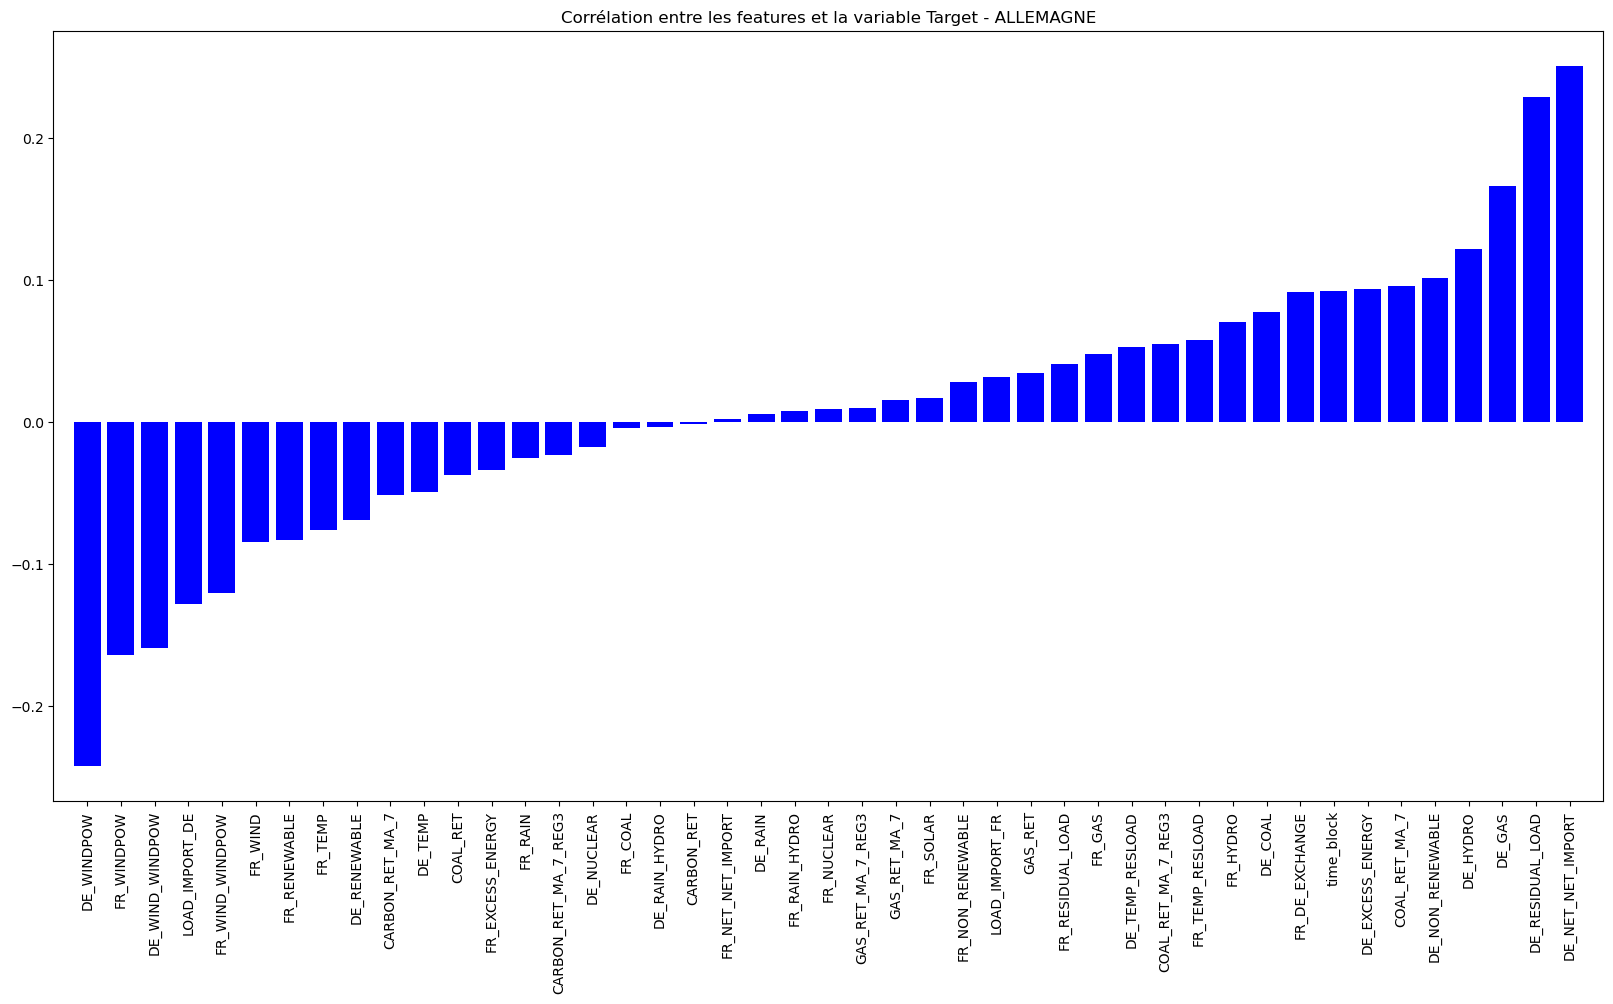

Variables avec |corrélation| > 0.2 (DE):
DE_WINDPOW          -0.242278
DE_RESIDUAL_LOAD     0.228842
DE_NET_NET_IMPORT    0.250983
dtype: float64


In [80]:
# Corrélations pour l'Allemagne (DE)
X_DE_filtered = X_tr[X_tr['COUNTRY'] == 0].copy()
y_DE_filtered = y_tr[y_tr.index.isin(X_DE_filtered.index)]

# Exclure COUNTRY et DAY_ID du calcul de corrélation
features_to_correlate = X_DE_filtered.drop(columns=['COUNTRY', 'DAY_ID'], errors='ignore')
corr_matrix_DE = features_to_correlate.corrwith(y_DE_filtered, method='pearson')
corr_matrix_DE = corr_matrix_DE.dropna().sort_values()

plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - ALLEMAGNE")
plt.bar(range(len(corr_matrix_DE)), corr_matrix_DE, color="blue", align="center")
plt.xticks(range(len(corr_matrix_DE)), corr_matrix_DE.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_DE)])
plt.show()


print("Variables avec |corrélation| > 0.2 (DE):")
print(corr_matrix_DE[abs(corr_matrix_DE) > 0.2])

#### Commentaires:

- Les variables les plus corrélées avec les variations du prix de l'electricité allemandes sont : "DE_WINDPOW", "DE_RESIDUAL_LOAD", "DE_NET_NET_IMPORT".

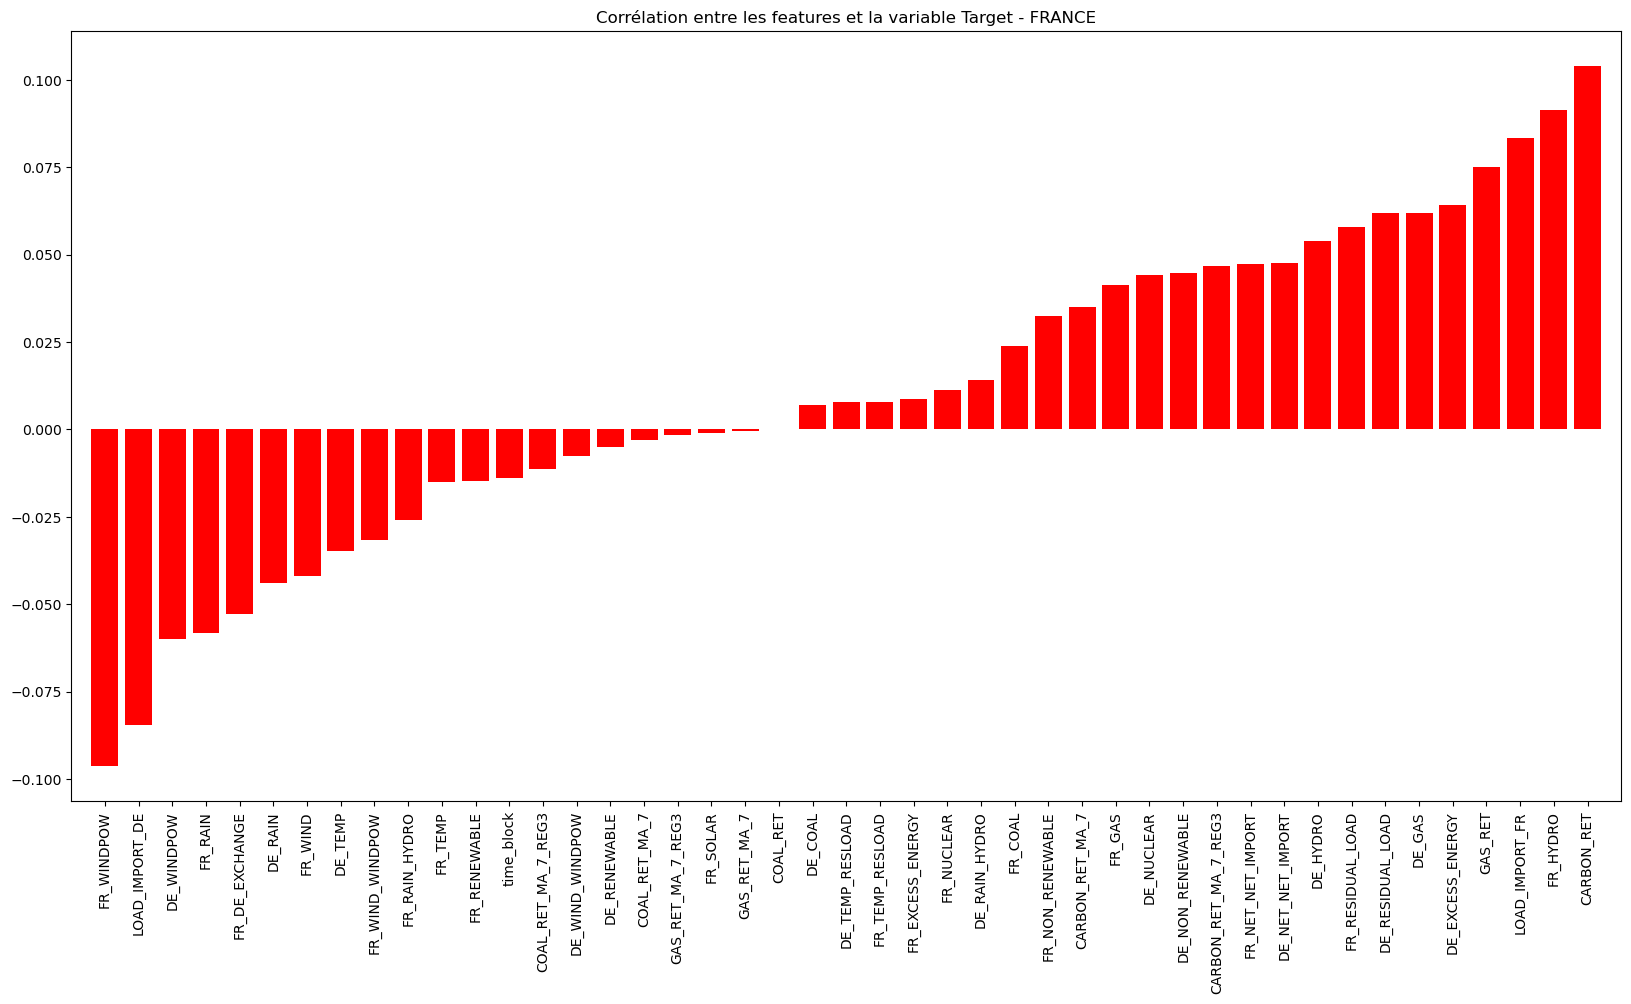

Series([], dtype: float64)
Variables avec |corrélation| > 0.2 (FR):


In [81]:
# Corrélations pour la France (FR)

X_FR_filtered = X_tr[X_tr['COUNTRY'] == 1].copy()
y_FR_filtered = y_tr[y_tr.index.isin(X_FR_filtered.index)]

# Exclure COUNTRY et DAY_ID du calcul de corrélation
features_to_correlate = X_FR_filtered.drop(columns=['COUNTRY', 'DAY_ID'], errors='ignore')
corr_matrix_FR = features_to_correlate.corrwith(y_FR_filtered, method='pearson')
corr_matrix_FR = corr_matrix_FR.dropna().sort_values()

plt.figure(figsize=(20, 10))
plt.title("Corrélation entre les features et la variable Target - FRANCE")
plt.bar(range(len(corr_matrix_FR)), corr_matrix_FR, color="red", align="center")
plt.xticks(range(len(corr_matrix_FR)), corr_matrix_FR.index, rotation='vertical')
plt.xlim([-1, len(corr_matrix_FR)])
plt.show()

print(corr_matrix_FR[abs(corr_matrix_FR) > 0.2])
print("Variables avec |corrélation| > 0.2 (FR):")

#### Commentaires:

- En général, les variables sont faiblements corrélées avec les variations du prix de l'electricité allemandes.

## Regression lineaire

Les prix de l’électricité ont des pics violents et imprévisibles donc une erreur de +50 €/MWh d'estimations est bien plus grave qu’une erreur de +5, donc nous utilisons le RMSE qui penalise fortement les grosses erreurs.

cf Day-Ahead electricity price forecasting.pdf

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X_tr, y_tr)
y_pred_tr = ols.predict(X_tr)
y_pred_val = ols.predict(X_val)

results_ols = {
    "RMSE_train": np.sqrt(mean_squared_error(y_tr, y_pred_tr)),
    "RMSE_val": np.sqrt(mean_squared_error(y_val, y_pred_val)),
    "R2_train": r2_score(y_tr, y_pred_tr),
    "R2_val": r2_score(y_val, y_pred_val)
}

results_ols

{'RMSE_train': np.float64(1.017048020072412),
 'RMSE_val': np.float64(0.9325910495508686),
 'R2_train': 0.08129155698704316,
 'R2_val': -0.03805896826058408}

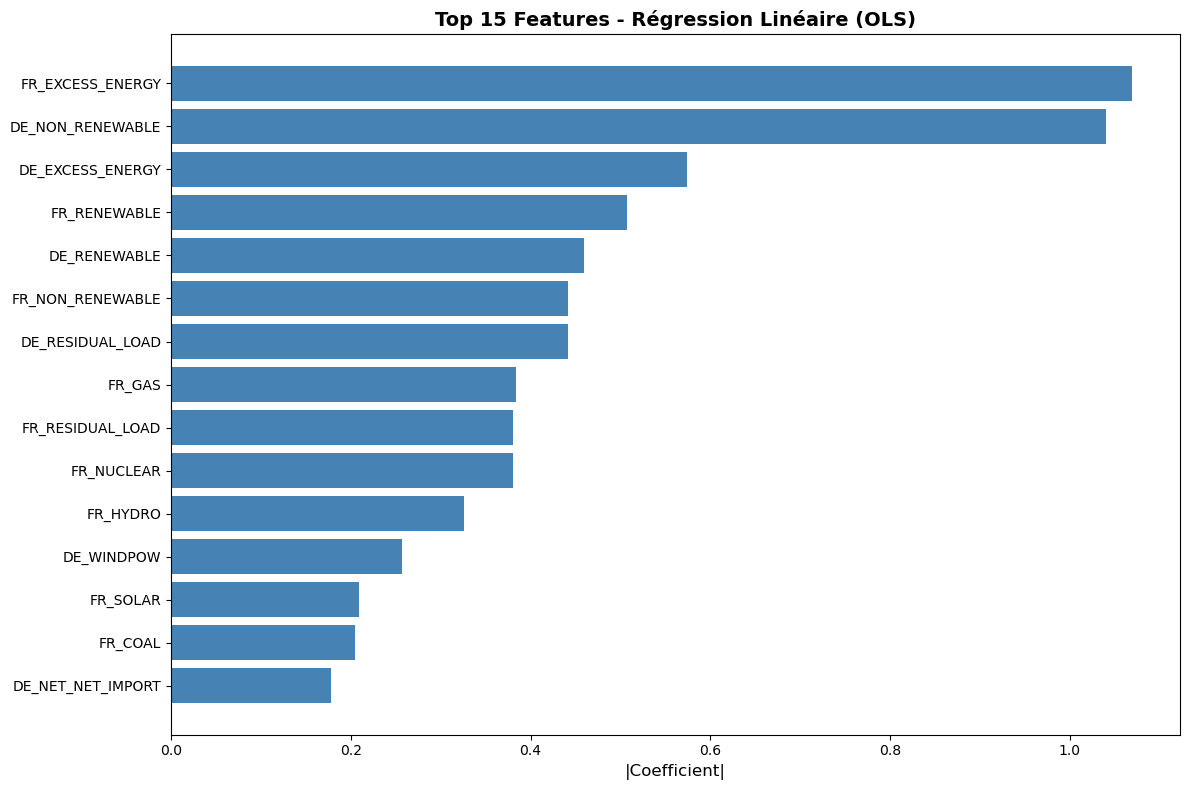

In [83]:
# Feature importance pour OLS (coefficients)
ols_coefs = pd.Series(ols.coef_, index=X_tr.columns).abs().sort_values(ascending=False)

# Graphique harmonisé
top_15_ols = ols_coefs.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(15), top_15_ols.values, color='steelblue')
plt.yticks(range(15), top_15_ols.index)
plt.xlabel('|Coefficient|', fontsize=12)
plt.title('Top 15 Features - Régression Linéaire (OLS)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

La variable target  se concentre autour de zéro, avec un écart-type de 1 enviton, mais également des valeurs extrêmes atteignant ±7. Le RMSE obtenu sur l’échantillon de validation (≈0.93) est du même ordre de grandeur que l’écart-type de la série, indiquant que le modèle linéaire ne parvient pas à réduire significativement la variance du prix.
Sur 75 % des jours, Y est entre −0.21 et +0.25, une erreur de 0.9 est énorme relativement. 
Ceci se traduit par un coefficient de détermination négatif sur l’échantillon de validation. Ce comportement est typique des modèles linéaires appliqués aux prix de l’électricité, dont la dynamique est fortement non linéaire et dominée par des épisodes de volatilité extrême.

## 2. Modèle - Regression (Lasso)

Pour le modele lasso, on effectue une cross validation pour trouver le parametre alpha optimal

In [84]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(max_iter=20000, random_state=42)

param_grid = {
    "alpha": np.logspace(-4, 2, 30)   # 1e-4 -> 1e2, assez standard
}

search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE (négatif car convention sklearn)
    n_jobs=-1
)

search.fit(X_tr, y_tr)

best = search.best_estimator_


pred_va = best.predict(X_val)
rmse_va_LASSO = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va_LASSO = mean_absolute_error(y_val, pred_va)
r2_va_LASSO = r2_score(y_val, pred_va)

print("Meilleur alpha :", search.best_params_["alpha"])
print("RMSE CV train  :", -search.best_score_)
print("Validation : RMSE:", rmse_va_LASSO, "MAE:", mae_va_LASSO, "R2:", r2_va_LASSO)

Meilleur alpha : 0.03039195382313198
RMSE CV train  : 1.0474025785515018
Validation : RMSE: 0.9068239953905847 MAE: 0.5746856610564766 R2: 0.018510753601871377


Nombre de features sélectionnées par Lasso : 14 / 47


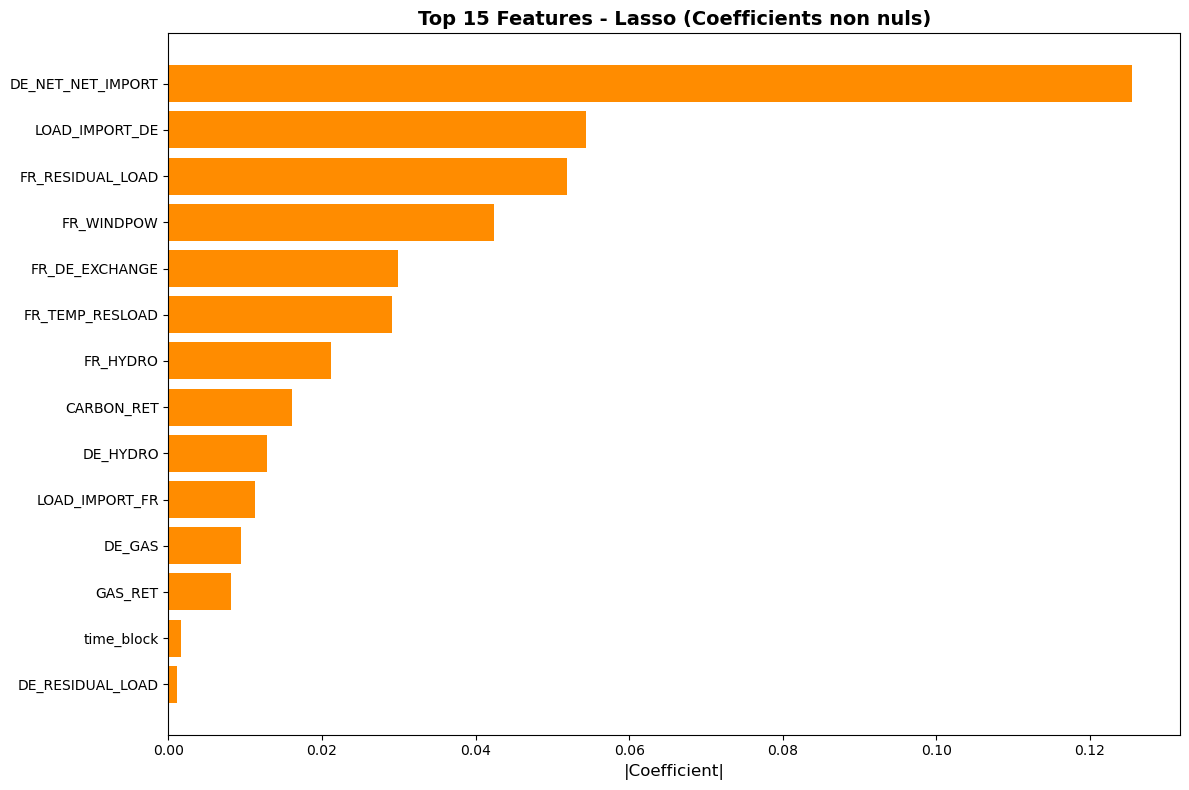

In [85]:
# Feature importance pour Lasso (coefficients non nuls)
lasso_coefs = pd.Series(best.coef_, index=X_tr.columns)
non_zero_coefs = lasso_coefs[lasso_coefs != 0].abs().sort_values(ascending=False)

print(f"Nombre de features sélectionnées par Lasso : {len(non_zero_coefs)} / {len(X_tr.columns)}")

# Graphique harmonisé
top_15_lasso = non_zero_coefs.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_15_lasso)), top_15_lasso.values, color='darkorange')
plt.yticks(range(len(top_15_lasso)), top_15_lasso.index)
plt.xlabel('|Coefficient|', fontsize=12)
plt.title('Top 15 Features - Lasso (Coefficients non nuls)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [86]:
# Création fichier soumission
import shutil

Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt.csv')

'../data/benchmark_qrt.csv'

Nous avons a peu pres le meme resultat que la regression lineaire ce qui n'est pas etonnant

## 3. Modèle - Random Forest Regressor

Nous avons un probleme de prevision de prix de l'electricité, avec des relations non lineaires comme nous l'avons vu, pas mal de correlation, des jours extremes. Random forest est un bon choix de model ensembliste car il est robuste au bruit et a la multicolinarité 

In [87]:

from sklearn.ensemble import RandomForestRegressor


#Modèle + grille d'hyperparamètres

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [300, 600],          # nb d'arbres
    "max_depth": [5, 10, 12], 
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, 0.8]   # nb de features testées à chaque split
}

search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",  # RMSE
    n_jobs=-1,
    verbose=1
)

search.fit(X_tr, y_tr)

best_rf = search.best_estimator_

print("Meilleurs hyperparamètres :", search.best_params_)
print("RMSE (CV train) :", -search.best_score_)


#Évaluation sur validation (hold-out)

pred_va= best_rf.predict(X_val)
rmse_va_RF = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va_RF = mean_absolute_error(y_val, pred_va)
r2_va_RF = r2_score(y_val, pred_va)

print("Validation -> RMSE:", rmse_va_RF, "MAE:", mae_va_RF, "R2:", r2_va_RF)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs hyperparamètres : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 600}
RMSE (CV train) : 1.0465472183536537
Validation -> RMSE: 0.9308703618888122 MAE: 0.6188837359896668 R2: -0.034231937197821694
Meilleurs hyperparamètres : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 600}
RMSE (CV train) : 1.0465472183536537
Validation -> RMSE: 0.9308703618888122 MAE: 0.6188837359896668 R2: -0.034231937197821694


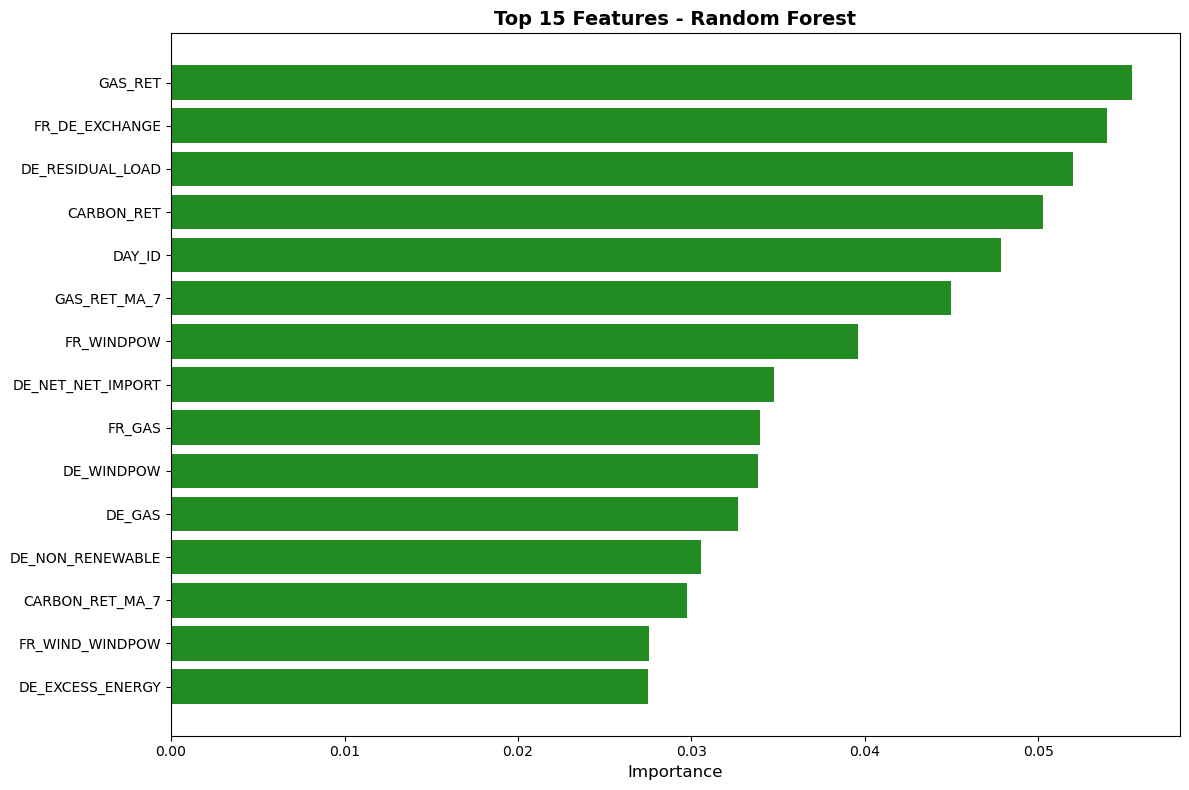

In [88]:
# Feature importance pour Random Forest

importances = pd.Series(best_rf.feature_importances_, index=X_tr.columns)\
               .sort_values(ascending=False)


# Graphique harmonisé
top_15_rf = importances.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(15), top_15_rf.values, color='forestgreen')
plt.yticks(range(15), top_15_rf.index)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Features - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [89]:
# Création fichier soumission avec Random Forest
Y_test_submission_rf = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission_rf['TARGET'] = best_rf.predict(X_test_clean)
Y_test_submission_rf.to_csv('benchmark_rf.csv', index=False)   

shutil.move('benchmark_rf.csv', '../data/benchmark_rf.csv')

'../data/benchmark_rf.csv'

## 3. Modèle - Réseau de Neurone

In [90]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y en vecteur 1D
ytr = y_tr.values.ravel()
yva = y_val.values.ravel()


mlp = MLPRegressor(
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    max_iter=3000
)

param_grid = {
    "hidden_layer_sizes": [(32,), (64,), (64, 32)],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [1e-3, 3e-4],
}

gs = GridSearchCV(
    mlp,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",   # MSE (compatible partout)
    n_jobs=-1
)

gs.fit(X_tr, ytr)

best_mlp = gs.best_estimator_
pred_val = best_mlp.predict(X_val)

mse_val= mean_squared_error(yva, pred_val)
rmse_val_mlp = np.sqrt(mse_val)            
mae_val_mlp = mean_absolute_error(yva, pred_val)
r2_val_mlp = r2_score(yva, pred_val)

rmse_cv = np.sqrt(-gs.best_score_)     

print("Meilleurs hyperparamètres :", gs.best_params_)
print("RMSE (CV train) :", rmse_cv)
print(f"Validation -> RMSE: {rmse_val_mlp:.6f}  MAE: {mae_val_mlp:.6f}  R2: {r2_val_mlp:.6f}")



Meilleurs hyperparamètres : {'alpha': 0.001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.0003}
RMSE (CV train) : 1.0952288613383652
Validation -> RMSE: 0.975865  MAE: 0.661030  R2: -0.136629


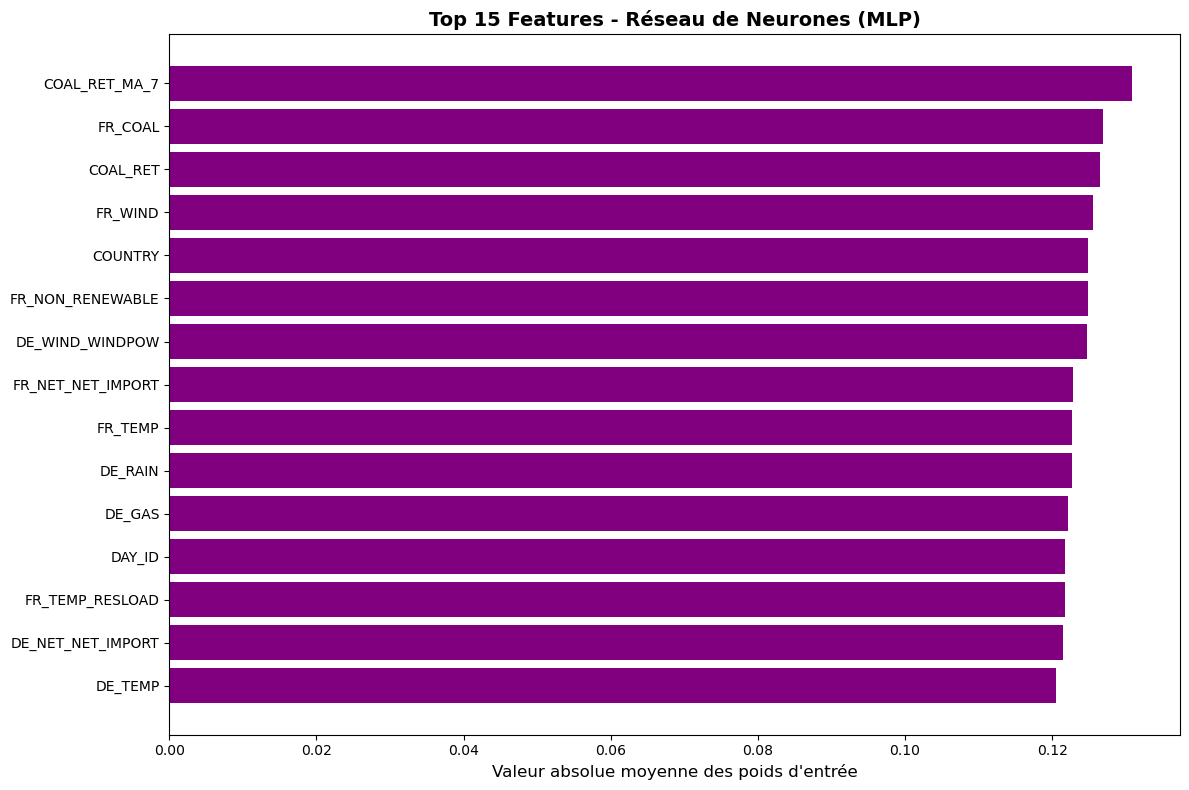

In [91]:
# Feature importance pour Neural Network

mlp_coefs = pd.Series(np.mean(np.abs(best_mlp.coefs_[0]), axis=1), index=X_tr.columns)
mlp_coefs = mlp_coefs.sort_values(ascending=False)

# Graphique harmonisé
top_15_mlp = mlp_coefs.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(15), top_15_mlp.values, color='purple')
plt.yticks(range(15), top_15_mlp.index)
plt.xlabel('Valeur absolue moyenne des poids d\'entrée', fontsize=12)
plt.title('Top 15 Features - Réseau de Neurones (MLP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [92]:
#Création fichier soumission avec MLP

Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best_mlp.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)
import shutil
shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt_mlp.csv')


'../data/benchmark_qrt_mlp.csv'

## 4. Modèle - XGBoost


In [93]:
#XGBoost model
import shutil
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9]
}
search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
search.fit(X_tr, y_tr)
best_xgb = search.best_estimator_
print("Meilleurs hyperparamètres :", search.best_params_)
print("RMSE (CV train) :", -search.best_score_)
#Évaluation sur validation (hold-out)
pred_va = best_xgb.predict(X_val)
rmse_va_xgb = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va_xgb= mean_absolute_error(y_val, pred_va)
r2_va_xgb = r2_score(y_val, pred_va)
print("Validation -> RMSE:", rmse_va_xgb, "MAE:", mae_va_xgb, "R2:", r2_va_xgb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x103183920>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/homebrew/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Meilleurs hyperparamètres : {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
RMSE (CV train) : 1.0444370788963784
Validation -> RMSE: 0.9310213294587393 MAE: 0.6076356601888682 R2: -0.03456742568179605


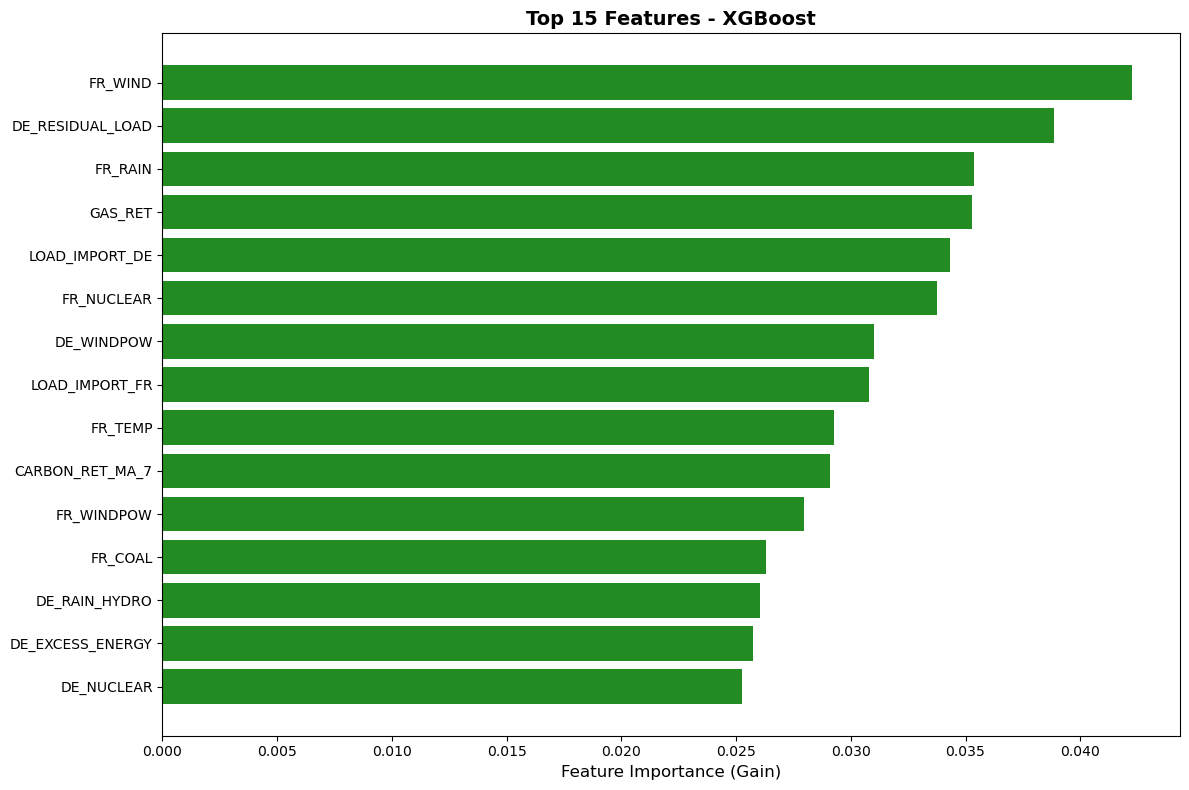

In [94]:
# Feature importance pour XGBoost
xgb_importances = pd.Series(best_xgb.feature_importances_, index=X_tr.columns).sort_values(ascending=False)


# Graphique harmonisé
top_15_xgb = xgb_importances.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(15), top_15_xgb.values, color='forestgreen')
plt.yticks(range(15), top_15_xgb.index)
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.title('Top 15 Features - XGBoost', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [95]:
Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best_xgb.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)

shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt_XGBoost.csv')   

'../data/benchmark_qrt_XGBoost.csv'

## 5. Modèle - Adaboost

In [96]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.inspection import permutation_importance

# Modèle de base + AdaBoost
base_model = DecisionTreeRegressor(max_depth=3, random_state=42)
adaboost_model = AdaBoostRegressor(estimator=base_model, random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# GridSearchCV
search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

search.fit(X_tr, y_tr)

best_adaboost = search.best_estimator_

print("Meilleurs hyperparamètres :", search.best_params_)
print("RMSE (CV train) :", -search.best_score_)


# Évaluation sur validation (hold-out)
pred_va = best_adaboost.predict(X_val)

rmse_va_adaB = np.sqrt(mean_squared_error(y_val, pred_va))
mae_va_adaB = mean_absolute_error(y_val, pred_va)
r2_va_adaB = r2_score(y_val, pred_va)

print("Validation -> RMSE:", rmse_va_adaB, "MAE:", mae_va_adaB, "R2:", r2_va_adaB)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres : {'learning_rate': 0.01, 'n_estimators': 200}
RMSE (CV train) : 1.0532098817067659
Validation -> RMSE: 0.9338457471357279 MAE: 0.6107044719716245 R2: -0.04085403311123503
Meilleurs hyperparamètres : {'learning_rate': 0.01, 'n_estimators': 200}
RMSE (CV train) : 1.0532098817067659
Validation -> RMSE: 0.9338457471357279 MAE: 0.6107044719716245 R2: -0.04085403311123503


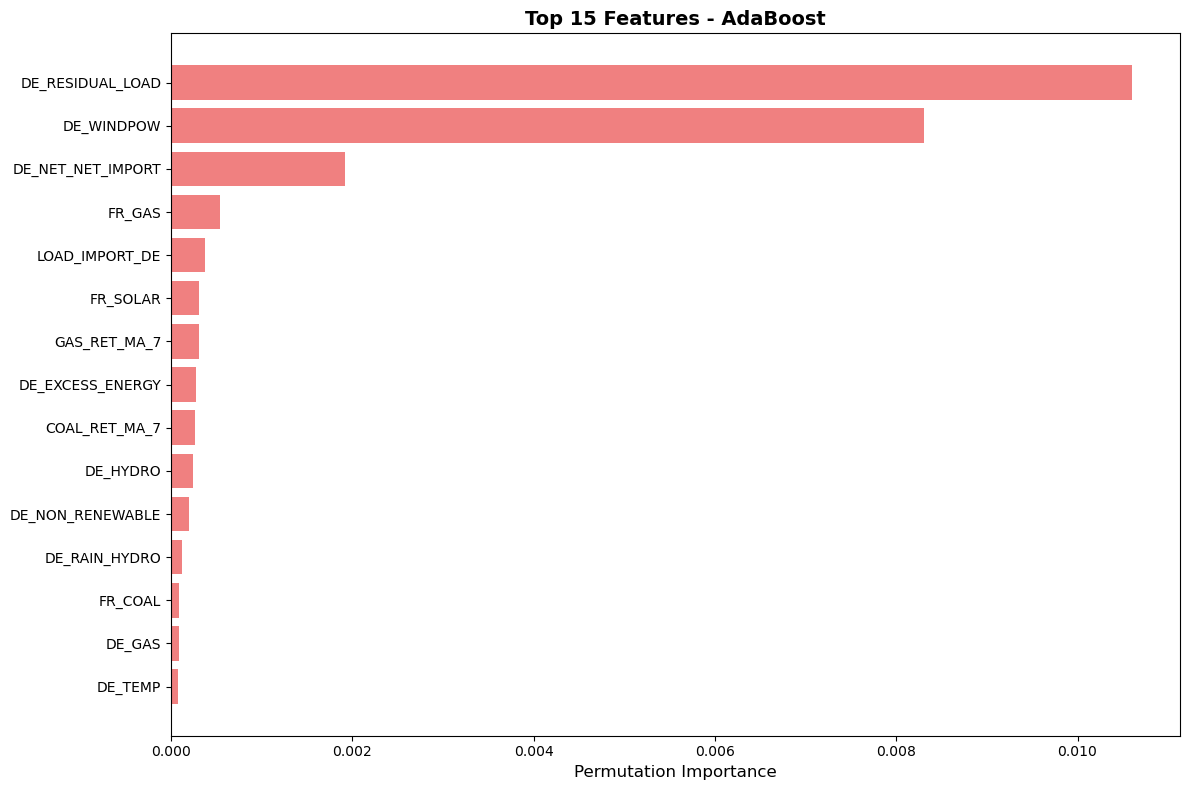

In [97]:
# Feature importance via permutation
result = permutation_importance(
    best_adaboost, X_val, y_val, n_repeats=30, random_state=42
)

feature_importance = result.importances_mean
top_features = pd.Series(feature_importance, index=X_val.columns).sort_values(ascending=False)

# Graphique harmonisé
top_15_ada = top_features.head(15).sort_values()
plt.figure(figsize=(12, 8))
plt.barh(range(15), top_15_ada.values, color='lightcoral')
plt.yticks(range(15), top_15_ada.index)
plt.xlabel('Permutation Importance', fontsize=12)
plt.title('Top 15 Features - AdaBoost', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [98]:
#création fichier soumission avec AdaBoost
Y_test_submission = X_test[['ID']].copy()
X_test_clean= X_test.drop(columns=["ID"], errors="ignore")
Y_test_submission['TARGET'] = best_adaboost.predict(X_test_clean)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)
shutil.move('benchmark_qrt.csv', '../data/benchmark_qrt_AdaBoost.csv')


'../data/benchmark_qrt_AdaBoost.csv'

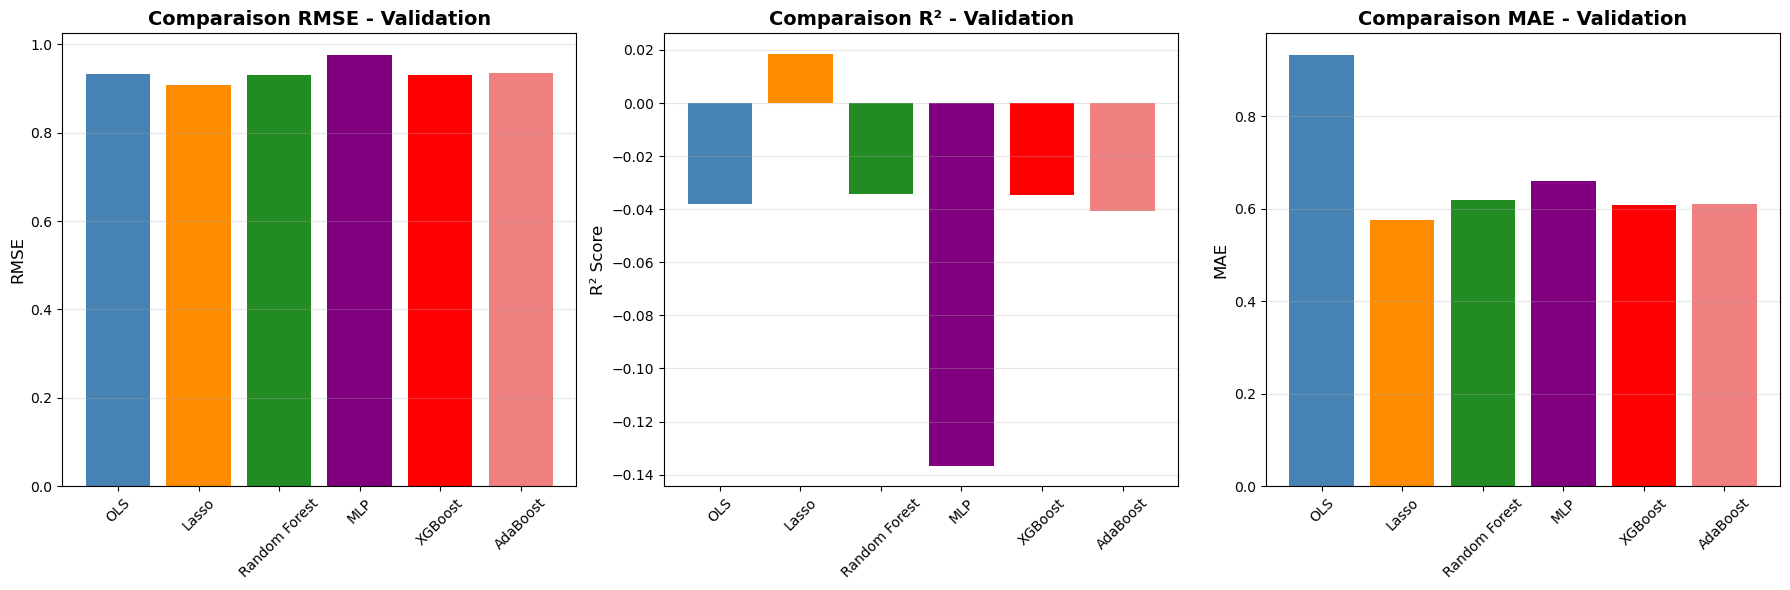


📊 Tableau récapitulatif des performances (Validation Set):


,Modèle,RMSE,R²,MAE
1,Lasso,0.906824,0.018511,0.574686
2,Random Forest,0.930870,-0.034232,0.618884
4,XGBoost,0.931021,-0.034567,0.607636
0,OLS,0.932591,-0.038059,0.932591
5,AdaBoost,0.933846,-0.040854,0.610704
3,MLP,0.975865,-0.136629,0.661030


In [99]:
# plot comparatif des performances des modèles évalués sur le jeu de validation
model_names = ['OLS', 'Lasso', 'Random Forest', 'MLP', 'XGBoost', 'AdaBoost']

rmse_values = [
    results_ols['RMSE_val'],
    rmse_va_LASSO, 
    rmse_va_RF,
    rmse_val_mlp,
    rmse_va_xgb, 
    rmse_va_adaB
]

rsquares_values = [
    results_ols['R2_val'],
    r2_va_LASSO,
    r2_va_RF,
    r2_val_mlp,
    r2_va_xgb,
    r2_va_adaB
]

mae_values = [
    np.sqrt(mean_squared_error(y_val, ols.predict(X_val))),  # Calcul MAE pour OLS
    mae_va_LASSO,
    mae_va_RF,
    mae_val_mlp,
    mae_va_xgb,
    mae_va_adaB
]

# Graphiques comparatifs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['steelblue', 'darkorange', 'forestgreen', 'purple', 'red', 'lightcoral']

# RMSE
axes[0].bar(model_names, rmse_values, color=colors)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('Comparaison RMSE - Validation', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(model_names, rsquares_values, color=colors)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Comparaison R² - Validation', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# MAE
axes[2].bar(model_names, mae_values, color=colors)
axes[2].set_ylabel('MAE', fontsize=12)
axes[2].set_title('Comparaison MAE - Validation', fontsize=14, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tableau récapitulatif
results_df = pd.DataFrame({
    'Modèle': model_names,
    'RMSE': rmse_values,
    'R²': rsquares_values,
    'MAE': mae_values
})

print("\n📊 Tableau récapitulatif des performances (Validation Set):")
display(results_df.sort_values('RMSE'))